In [1]:
import torch
import matplotlib.pyplot as plt

# Modelos Neuronales I
Autor: Jorge García González (Universidad de Málaga)

Última Actualización: 25/09/2025

Asignatura: Programación para la Inteligencia Artificial



Hasta ahora hemos hablado del aprendizaje y lo hemos planteado simplemente como el ajuste de parámetros de un modelo. Dicho ajuste lo hemos realizado valiéndonos de las propiedades del gradiente del error que comete el modelo respecto a dichos parámetros para unos datos concretos. Esa estrategia es a grandes rasgos lo que se conoce como el método del Descenso del Gradiente Estocástico (Stochastic Gradient Descent).

Ahora vamos a centrarnos en el modelo a optimizar. De nuevo vamos a rescatar algunas funciones de sesiones anteriores:

In [26]:
def get_data_from_a_line(m, b, n, sigma=2, range=50):
  """
  Función que devuelve datos a partir de una recta. Recordemos que la ecuación de la recta está definida por y=mx+b.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    n: número de datos que queremos obtener.
    sigma: desviación típica para el ruido que añadiremos a los datos (2 por defecto).
    range: extremo del rango [0,rango] en el eje x en el que queremos situar los datos (50 por defecto).
  """
  x = range*torch.rand(n)                                               # Generamos los datos en el eje x.
  y = m*x+b                                                             # Obtemeos la posición correspondiente en el eje y.
  noise_x = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje x.
  noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje y.
  x_with_noise = x + noise_x
  y_with_noise = y + noise_y

  data = torch.cat((x_with_noise[:,None], y_with_noise[:,None]), dim=1)
  return data

def line_model(m, b, inputs):
  """
  Functión para modelar una recta.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    inputs: vector con los valores de entrada para ser calculados por el modelo.
  """
  return m*inputs+b

Hasta ahora hemos trabajado con un modelo lineal. Sirve para modelar una recta en 2 dimensiones. Cualquier recta en 2 dimensiones, pero solo rectas en 2 dimensiones. Por poder, se puede intentar ajustar un modelo lineal a cualquier conjunto de datos y minimizar el error, pero lo máximo que conseguiríamos sería una recta que quede más o menos centrada respecto a los datos. Nada que consideremos un ajuste razonable.

Por eso hace falta un modelo más potente. Más *flexible*. Y es ahí donde entran los modelos neuronales.

Llamamos Redes Neuronales Artificiales (RNA o ANN por sus siglas en inglés) a los modelos que combinan neuronas artificiales formando un grafo. Un ejemplo típico es el de un perceptrón:

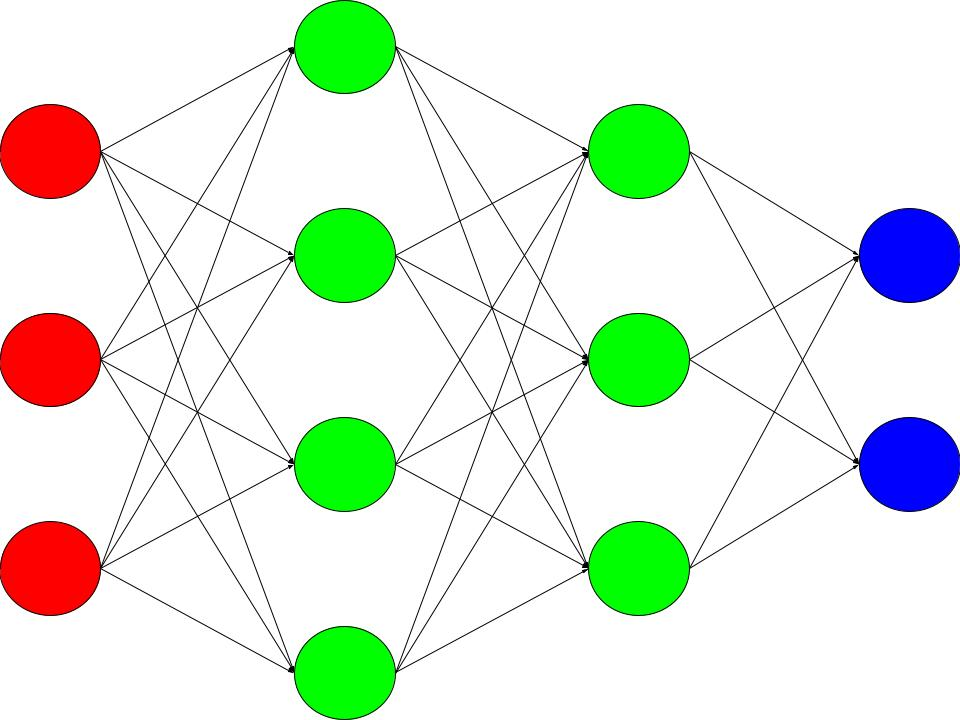

Ahora no es relevante qué representan los círculos rojos, verdes y azules. Lo relevante es que en conjunto representan un grafo en el que hay unas unidades de cómputo que llamamos neuronas y las salidas de unas unidades de cómputo se convierten en las entradas de otras.

Una neurona artificial es una función matemática que se inspira en el funcionamiento de las neuronas naturales. Es un modelo bioinspirado, pero el objetivo no es modelar el funcionamiento biológico. Las neuronas artificiales no están limitadas por modelar las neuronas anturales, sino que toman ideas de su funcionamiento. De ahora en adelante nos referiremos siempre a neuronas artificiales, así que por simplicidad omitiremos el *artificiales* y simplemente hablaremos de neuronas.

Como hemos dicho, una neurona es una función matemática. Hay diversos tipos de estas funciones en la bibliografía (lineales, convolucionales, LSTM, etc) con utilidades distintas. Nosotros nos vamos a centrar en la neurona clásica. También denominada neurona lineal o densa, que se define como:

*y* = *a*(∑*w*ᵢ*x*ᵢ-*b*)

Siendo **w** un vector de pesos, **x** un vector de entradas, *b* un valor umbral (también llamado desviación o *bias*) y *a* una función de activación. Los parámetros que se ajustan son **w** y *b*.

Antes de entrar en la arquitectura, vamos a pensar detenidamente en la fórmula de la neurona clásica. Por ahora supongamos que *a* es la función identidad *f*(*x*)=*x* (la ignoramos). Nos queda la función *y*=∑*w*ᵢ*x*ᵢ-*b*. Supongamos además que los vectores **w** y **x** tienen una única componente. Podemos reducirlo a *y*=*wx*-*b*. ¡Un momento! ¡Esa es la ecuación de la recta en 2D! Si la extendemos un poco tenemos *y*=*wᵢx*+*wⱼx*-*b* que representa un plano y así podemos seguir extendiendo dimensiones. Si *a* es la función identidad, nuestra neurona no es más que una función lineal y una función lineal se caracteriza por tener siempre la misma inclinación. Vamos a verlo en 2D.

Para empezar, vamos a crear algunas funciones que permitan usar polinomios y generar datos a partir de un polinomio.

In [2]:
def generate_polynomial(c_list):
  """
  Función para generar una función que aplique un polinomio.
  Args:
    c_list: Lista de coeficientes del polinomio. ej: [2,1,0] representa el polinomio y = 2x**2 + x + 0
  """
  def apply_polynomial(x):
    """
    Función para aplicar un polinomio.
    Args:
      x: las entradas a las que aplicarle el polinomio.
    """
    y = torch.cat([c*x[None,:]**index for index, c in enumerate(reversed(c_list))]).sum(dim=0)  # Para cada coeficiente (desde el final) operamos todas
                                                                                                # las x elevándolo a su índice (0,1,2,etc) y obtenemos
                                                                                                # una fila.
                                                                                                # El cat concatena las filas, así cada columna tiene,
                                                                                                # para un solo x, las operaciones de cada término del
                                                                                                # polinomio.
                                                                                                # Finalmente sumamos a lo largo de las columnas.
    return y

  return apply_polynomial

def get_data_from_a_polynomial(poly, n, sigma=2, range=50):
  """
  Función que devuelve datos a partir de una recta. Recordemos que la ecuación de la recta está definida por y=mx+b.
  Args:
    poly: Función que aplica un polinomio.
    n: número de datos que queremos obtener.
    sigma: desviación típica para el ruido que añadiremos a los datos (2 por defecto).
    range: extremo del rango [0,rango] en el eje x en el que queremos situar los datos (50 por defecto).
  """
  x = range*torch.rand(n)                                                             # Generamos los datos en el eje x.
  y = poly(x)                                                                         # Obtenemos los valores del polinomio para cada x.
  noise_x = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y))               # Generamos un vector de ruido gaussiano para el eje x.
  noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y))               # Generamos un vector de ruido gaussiano para el eje y.
  x_with_noise = x + noise_x
  y_with_noise = y + noise_y

  data = torch.cat((x_with_noise[:,None], y_with_noise[:,None]), dim=1)
  return data

def draw_2D_function(function, range=[-4,4], function_label = None, title = None, data=None):
  plt.figure(figsize=(8,6))
  if data is not None:
    plt.scatter(data[:,0], data[:,1])
    x = torch.linspace(data[:,0].min(), data[:,0].max(), 100)
  else:
    x = torch.linspace(range[0], range[1], 100)
  y = function(x)
  plt.plot(x, y, label=function_label)

  if title is not None:
    plt.title(title)
  if function_label is not None:
    plt.legend()
  plt.grid(True)
  plt.show()


Nota: Sí. La función generate_polynomial genera otras funciones. Con esas funciones puedo generar polinomios de los que generar datos con un poco de ruido como hacíamos con las rectas. Por ejemplo, del polinomio y=x<sup>2</sup>:

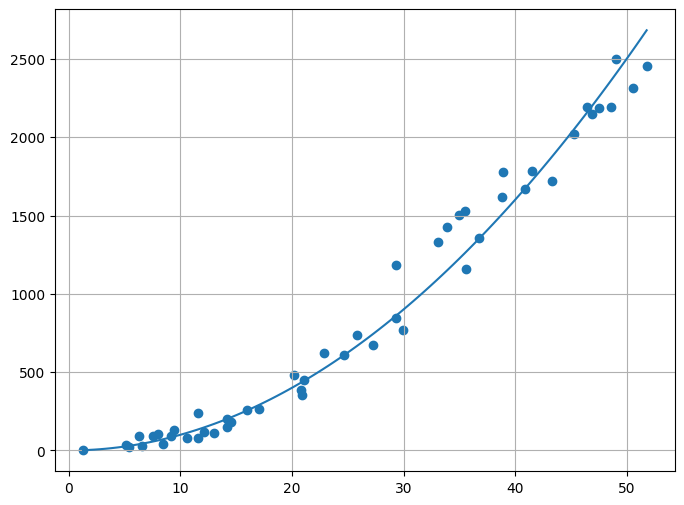

In [28]:
polynomial_cofficients = [1,0,0]
polynomial = generate_polynomial(polynomial_cofficients)
data = get_data_from_a_polynomial(polynomial, 50)
draw_2D_function(polynomial, data=data)

¿Cómo puedo representar esa curva con un modelo lineal de la forma y=mx+b? ¡La inclinación de ese modelo va a ser siempre m! Su derivada respecto a x es constante, lo que quiere decir que la función no se *dobla* en ningún lugar. No puede tener curvas. Lo mismo pasa con todo modelo lineal con más variables. La inclinación es siempre la misma. Además, combinar muchos modelos lineales da como resultado otro modelo lineal.

Vamos a verlo en una prueba sencilla:

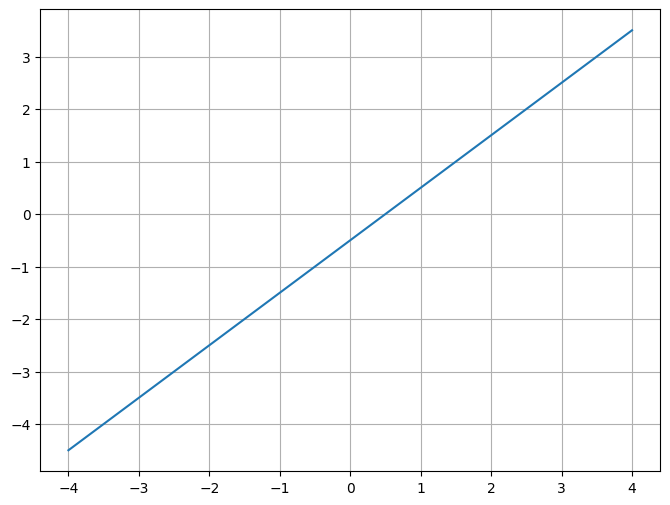

In [29]:
def wrapper_function(inputs):
  return line_model(4,1, inputs) + line_model(-3,-1.5, inputs)
draw_2D_function(wrapper_function)

Nota: un wrapper en programación es una función intermedia que sirve para hacer compatibles distintas funciones. Una función intermediaria, por así decirlo.

Si cambiamos los valores de m y b de los modelos lineales anteriores el resultado siempre es otro modelo lineal. Al fin y al cabo:

y=(m<sub>1</sub>x+b<sub>1</sub>)+(m<sub>2</sub>x+b<sub>2</sub>) = (m<sub>1</sub>+m<sub>2</sub>)x+(b<sub>1</sub>+b<sub>2</sub>)

Si intentamos combinarlos secuencialmente (que la salida de uno sea la entrada de otro que es lo mismo que hacer la composición de ambos).



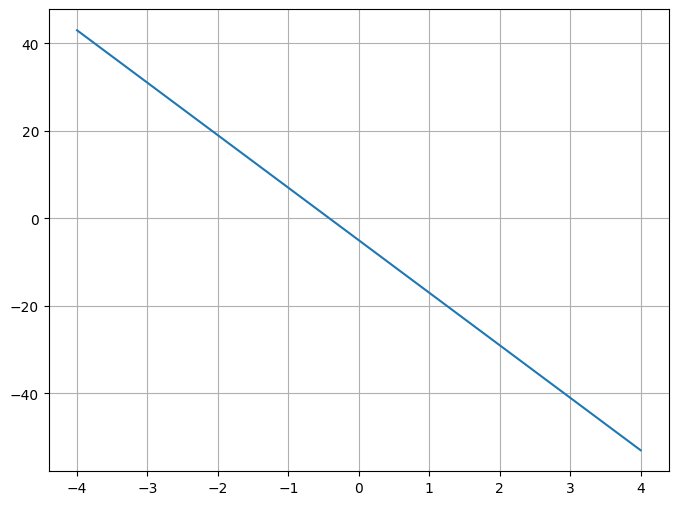

In [30]:
def wrapper_function(inputs):
  return line_model(4,1, line_model(-3,-1.5, inputs))
draw_2D_function(wrapper_function)

¡Vuelve a ser otra línea recta!

y = (m<sub>1</sub>(m<sub>2</sub>x+b<sub>2</sub>)+b<sub>1</sub>) = m<sub>1</sub>m<sub>2</sub>x+m<sub>1</sub>b<sub>2</sub>+b<sub>1</sub>

Si sumar modelos lineales y componerlos tiene como resultado otros modelos lineales, ¿Dónde está el truco de las redes? Por mucho que cree un grafo con muchas neuronas clásicas, el resultado siempre iba a ser una recta. ¿Qué les otorga flexibilidad? El truco  está en el elemento que hemos dejado *inutilizado*, la función de activación.

La función y=x<sup>2</sup> tiene esta forma:



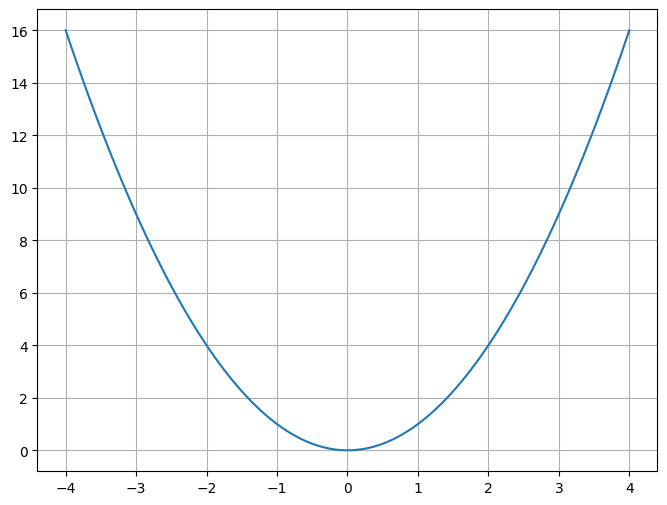

In [31]:
polynomial_cofficients = [1,0,0]
polynomial = generate_polynomial(polynomial_cofficients)
draw_2D_function(polynomial)

Si combinamos un par de modelos lineales a los que añadimos unas funciones de activación (de las que ahora hablaremos), obtenemos algo así:


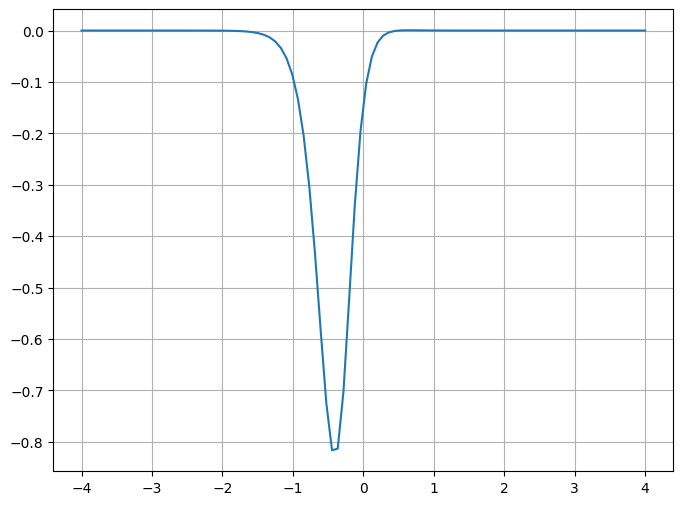

In [32]:
def wrapper_function(inputs):
  return torch.tanh(line_model(4,1, inputs)) + torch.tanh(line_model(-3, -1.5, inputs))
draw_2D_function(wrapper_function)

Vale. No son la misma función. Ni siquiera tienen la misma forma, pero se parecen más. Y lo más importante, ¡No es una línea recta! La función de activación permite representar algo más que líneas rectas. Concretamente la función que hemos utilizado es la tangente hiperbólica (abreviado típicamente a tanh) Y es una función de activación habitual que tiene la forma:


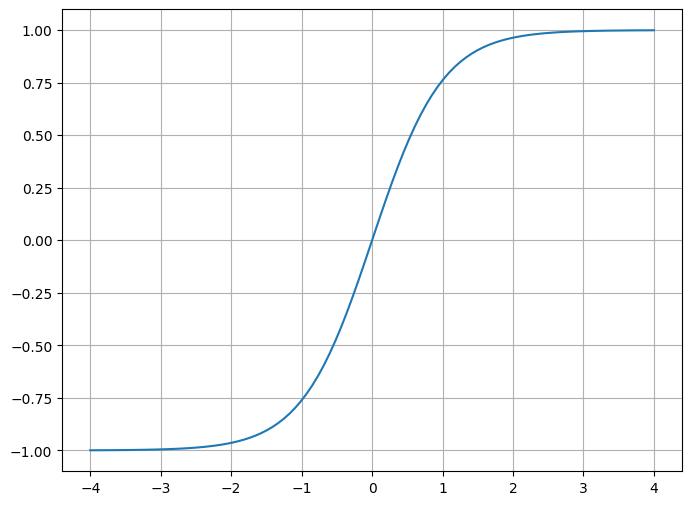

In [33]:
draw_2D_function(torch.tanh)

Su fórmula es:

tanh(x) = (e<sup>x</sup>-e<sup>-x</sup>)/(e<sup>x</sup>+e<sup>-x</sup>)

Y como características destacadas diremos que es derivable en todo su dominio y su resultado está en (-1,1).

vamos a ver otras funciones de activación relevantes.

La función logistica (típicamente llamada sigmoide, aunque técnicamente es un caso particular de función sigmoide):


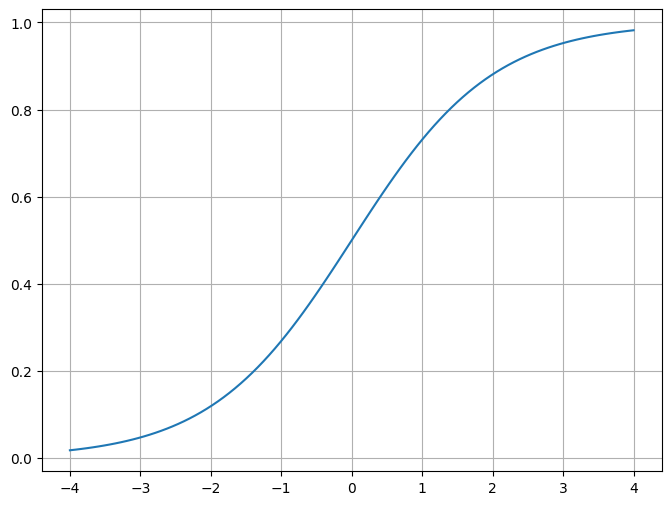

In [34]:
draw_2D_function(torch.sigmoid)

sigmoid(x) = 1/(1+e<sup>-x</sup>)

También derivable y con resultados en (0,1).

La función Linear Rectificada (abreviada ReLU por Rectified Linear Unit):

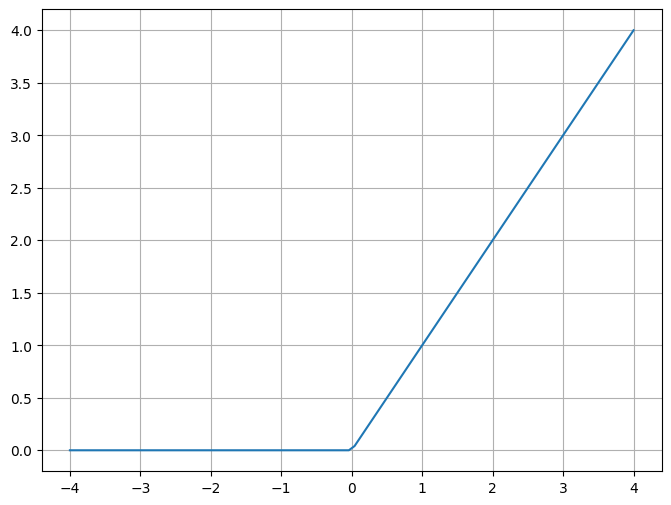

In [35]:
draw_2D_function(torch.relu)

ReLU(x) = max(0,x)

Esta no es derivable en todo su dominio ya que su derivada no está definida en el 0, pero ya hemos visto que eso no siempre es un problema (en ese casos se suele elegir arbitrariamente que la derivada sea 0 o 1). Su resultado esta en [0,+∞).

La LeakyReLU:

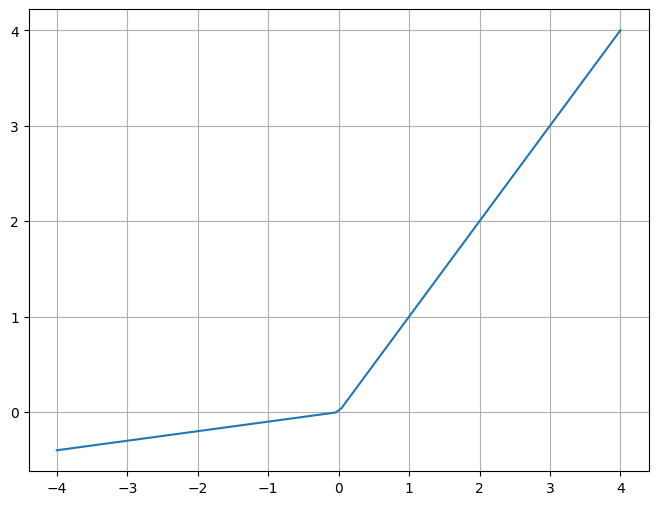

In [36]:
leaky_relu = torch.nn.LeakyReLU(negative_slope=0.1)
draw_2D_function(leaky_relu)

LeakyReLU(x) = max(0,x) + negative_slope*min(0,x)

En este caso la función vuelve a no ser derivable en todo el dominio, pero con la ReLU se puede elegir un valor arbitrario (1 o la inclinación negativa) para la derivada en el 0. Su resultado está en (-∞,+∞).

Nota histórica: Cuando la función de activación es la función paso (f(x)= 1 si x>=1 y 0 si x<0), a esta neurona se la llama neurona de McCulloch-Pitts (los que la propusieron en 1943) y de ese paso de *activación* cuando el sumatorio supera el umbral viene la terminología de activación y umbral.

Hay muchas otras funciones de activación (alguna más veremos en el futuro), pero estas son las más importantes para cualquier problema de regresión en Aprendizaje Profundo.

¿Qué tienen en común?

*   No son funciones lineales. ¡Ya hemos visto que componer funciones lineales tiene como resultado otra función lineal! Justamente queremos que las funciones de activación rompan esa linealidad para permitir a las redes neuronales ajustarse a funciones no lineales.
*   Son derivables o los puntos en los que no son derivables los podemos evitar asignando valores razonables sin provocar problemas numéricos. Recordemos que nuestra estrategia de entrenamiento se basa en el gradiente y para eso tenemos que poder obtener derivadas parciales.
*   Tienen al menos un rango *sensible*. Rangos en los que cambios no triviales en la entrada provocan cambios no triviales en la salida.

¿Qué se puede observar en algunas de ellas?

Varias tienen rangos no *sensibles*. Son asintotas en las que cambios en la entrada provocan poco o ningún cambio en la salida. ¡En esas asíntotas la derivada es 0! Si aplicamos la regla de la cadena con una función de activación en su rango insensible, el gradiente se convierte en 0. ¡No podemos ajustar nada! A este problema se le llama el Problema de Desvanecimiento de Gradiente (*Vanishing Gradient Problem*) y es un problema relativamente frecuente a la hora de entrenar modelos. Por eso hay que tener cuidado con el rango de valores en el que se inicializan los modelos y en el que están los datos. Si una neurona se inicializa con parámetros en valores que operados por los datos saquen a la función de su rango sensible, esa neurona no va a poder aprender.

Para terminar este cuaderno vamos a actualizar nuestro ejemplo algoritmo de aprendizaje usando la neurona lineal de PyTorch y esta vez vamos a optimizar ambos parámetros.

Linear(in_features=1, out_features=1, bias=True)
--------- step 0
m,b actual: (Parameter containing:
tensor([[0.2846]], requires_grad=True), Parameter containing:
tensor([-0.2452], requires_grad=True))
Valor medio de y: 9.680885314941406
Valor medio de y predicho: 5.584117889404297
Gradiente: [tensor([[-18.3109]]), tensor([-0.8000])]
--------- step 1
m,b actual: (Parameter containing:
tensor([[0.3029]], requires_grad=True), Parameter containing:
tensor([-0.2444], requires_grad=True))
Valor medio de y: 9.680885314941406
Valor medio de y predicho: 5.959984302520752
Gradiente: [tensor([[-17.1880]]), tensor([-0.7200])]
--------- step 2
m,b actual: (Parameter containing:
tensor([[0.3201]], requires_grad=True), Parameter containing:
tensor([-0.2437], requires_grad=True))
Valor medio de y: 9.680885314941406
Valor medio de y predicho: 6.312768459320068
Gradiente: [tensor([[-17.1880]]), tensor([-0.7200])]
--------- step 3
m,b actual: (Parameter containing:
tensor([[0.3373]], requires_grad=True)

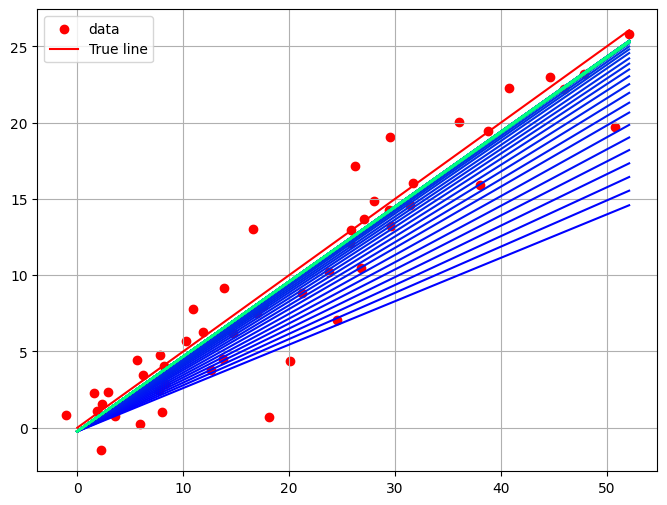

In [42]:
true_m, true_b = [0.5,0]
data = get_data_from_a_line(true_m, true_b, 50)

learning_rate = 1e-3
steps = 80
loss_fn = torch.nn.L1Loss()

model = torch.nn.Linear(1,1)

m = model.weight
b = model.bias
line_evolution_m = [m[0].clone().detach()]               # A las listas no añadimos el parámetro, sino una copia que nos aseguramos
line_evolution_b = [b.clone().detach()]               # de sacar del grafo usando un detach()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
)

x_true = data[:,0][:,None]
y_true = data[:,1][:,None]

for step in range(steps):
  y_pred = model(x_true)                              # Forward
  optimizer.zero_grad()
  loss = loss_fn(y_pred, y_true)
  loss.backward()                                     # Backward
  m = model.weight
  b = model.bias
  grad = [m.grad, b.grad]
  print(f"--------- step {step}")
  print(f"m,b actual: {m,b}")
  print(f"Valor medio de y: {y_true.mean()}")
  print(f"Valor medio de y predicho: {y_pred.mean()}")
  print(f"Gradiente: {grad}")
  optimizer.step()

  line_evolution_m.append(m[0].clone().detach())
  line_evolution_b.append(b.clone().detach())

plt.figure(figsize=(8,6))
colors = plt.cm.winter(torch.linspace(0,1,steps+1))
for index, (m, b) in enumerate(zip(line_evolution_m, line_evolution_b)):
  plt.plot([0,x_true.max()], [m*0+b,m*x_true.max()+b], c=colors[index])
plt.scatter(x_true, data[:,1], marker='o', c='r', label="data")
plt.plot([0,x_true.max()], [true_m*0+true_b,true_m*x_true.max()+true_b], c='r', label="True line")
plt.legend()
plt.grid(True)
plt.show()

En esta versión de nuesto algoritmo de aprendizaje hay varios cambios. Para empezar, nuestro modelo lo inicializamos con un torch.nn.Linear(1,1). Dentro de torch.nn están generalmente las utilidades específicas de Redes Neuronales (Neural Networks). torch.nn.Linear() es la clase que representa una capa de neuronas lineales. Ya hablaremos de capas más adelante. Por ahora basta entender que el primer argumento indica el tamaño de entrada (en nuestro caso 1 ya que solo hay una variable) y el segundo argumento indica el tamaño de salida (que coincide con el número de neuronas en la capa) y en nuestro caso es 1 porque queremos representar una única función lineal. Nótese que no le indicamos la función de activación. Por defecto asume que no hay. Nuestra m y nuestra b la tenemos que extraer ahora de la neurona (su único peso y su bias).

Lo segundo llamativo es que ya no tenemos explícitamente nuestra regla de aprendizaje. Lo hemos sustituido por añadir el optimizador SGD (Stochastic Gradient Descent). Un optimizador es una clase que gestiona el aprendizaje de la red. Se le indican los parámetros de cuyo aprendizaje tiene que ocuparse y el ratio de aprendizaje y cuando llega el momento de actualizar esos parámetros se le indica que ejecute un paso de aprendizaje (.step). Esto enmascara y simplifica el código, además de facilitar hacer cambios rápidos alterando el algoritmo de aprendizaje. No tenemos que preocuparnos por ejecutar la actualización sin afectar el grafo de computación y llamando a zero_grad() los gradientes de todos los parámetros se resetearan a 0. El optimizador se encarga. Ya hablaremos más de optimizadores en el futuro.




Vale. Ya hemos visto cómo usar una neurona lineal en PyTorch y optimizarla para ajustar la recta, pero ¿qué pasa con la función y=x<sup>2</sup>? ¿Permite la neurona lineal con una función de activación adecuada ajustarla?

Depende. Ninguna función de activación de las que hemos comentado permite ajustar una función con esa forma. El rango de salida de la función sigmoide o la tangente hiperbólica no es el mismo que el de y=x<sup>2</sup> así que esperar que sirva para ajustarla no tiene mucho sentido. ¿Y usando una ReLU o LeakyReLU? El rango de salida de la ReLU es el mismo que el de y=x<sup>2</sup>. Ambas van de 0 a infinito. No cuesta nada probar...

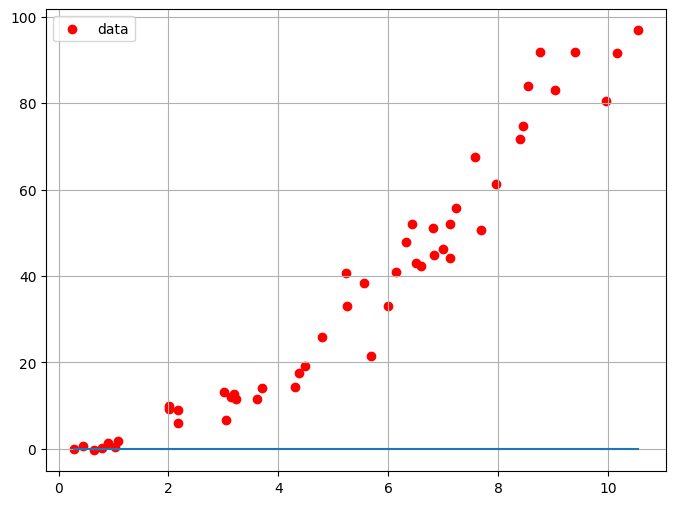

In [3]:
polynomial_cofficients = [1,0,0]
polynomial = generate_polynomial(polynomial_cofficients)
data = get_data_from_a_polynomial(polynomial, 50, sigma=0.5, range=10)

learning_rate = 1e-3
steps = 8000
loss_fn = torch.nn.L1Loss()

model = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.ReLU(),
)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
)

x_true = data[:,0][:,None]
y_true = data[:,1][:,None]

for step in range(steps):
  y_pred = model(x_true)                              # Forward
  optimizer.zero_grad()
  loss = loss_fn(y_pred, y_true)
  loss.backward()                                     # Backward
  optimizer.step()

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

Pues parece que la ReLU no nos soluciona el problema. De hecho.. ¡Ha aprendido una recta! ¿Y la LeakyReLU?

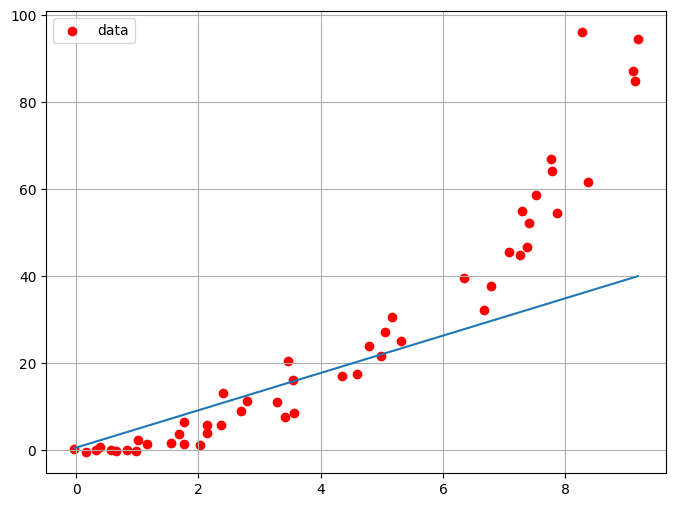

In [48]:
polynomial_cofficients = [1,0,0]
polynomial = generate_polynomial(polynomial_cofficients)
data = get_data_from_a_polynomial(polynomial, 50, sigma=0.5, range=10)

learning_rate = 1e-3
steps = 8000
loss_fn = torch.nn.L1Loss()

model = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.LeakyReLU(),
)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
)

x_true = data[:,0][:,None]
y_true = data[:,1][:,None]

for step in range(steps):
  y_pred = model(x_true)                              # Forward
  optimizer.zero_grad()
  loss = loss_fn(y_pred, y_true)
  loss.backward()                                     # Backward
  optimizer.step()

plt.figure(figsize=(8,6))
x = torch.linspace(x_true.min(), x_true.max(), 100)[:,None]
y = model(x).detach()
plt.plot(x, y)
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.legend()
plt.grid(True)
plt.show()

Otra dichosa recta. ¿Pero no habíamos dicho que el truco estaba en la función de activación? Una función de activación no es más que una función matemática, así que podríamos usar como función de activación a(x)=x<sup>2</sup> y así conseguir la forma que tenemos. Sería una opción, pero esa forma de razonar solo tiene sentido si sabemos que los datos se ajustan bien a y=x<sup>2</sup>. ¿Cómo lo sabemos? En este caso porque hemos creado los datos artificialmente a partir de ese polinomio, pero en un caso real no sabemos a qué función se corresponden los datos. Necesitamos un modelo flexible que pueda ajustar funciones desconocidas. La flexibilidad de las redes no está en usar una única neurona, sino en usar muchas combinadas. De eso vamos a hablar en el siguiente cuaderno.

Conclusiones:


*   La neurona clásica es una función lineal que necesita una función de activación no lineal para poder aprender algo que no sean rectas.
*   Hay muchas funciones de activación muy variadas con distintos rangos de salida que condicionarán la misma.
*   Las funciones de activación tienen unos rangos en las que son útiles, pero pueden quedar inutilizadas fuera de esos rangos porque el gradiente en esos puntos se vuelva 0 y no se pueda seguir aprendiendo.
*   PyTorch ya incluye la neurona clásica implementada (entre otras).
*   PyTorch enmascara los pasos del algoritmo de actualización de los pesos para simplificar el código mediante los optimizadores.
*   Una sola neurona no es muy flexible.